In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# canny edge detection more robust to noise than simple sobel filter
# implementation of kernel functions

def gaussian_filter(): # removes noise in image by blurring it (since we're focusing on the edges not the details)
    pass
    

class CNN(nn.Module):
    def __init__(self, rectangle_width, sharpness):
        super(CNN, self).__init__()
        #choosing device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # move tensors to device using  .to(device)

class pathDataset(Dataset): # dataloader
    def __init__(self, imgs_dir, transform):
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.all_imgs = os.listdir(imgs_dir)
    def __len__(self):
        return len(self.all_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imgs_dir, self.all_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

torch.Size([2, 1, 144, 256])


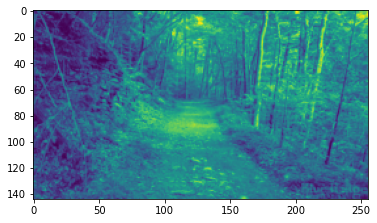

In [3]:
colorjitter = transforms.ColorJitter(.2,.3,.4,.5) # random values for now
grey = transforms.Grayscale(num_output_channels=1) # single channel image, 3 channels has r=g=b greyscale
tensor = transforms.ToTensor()
resize = transforms.Resize(size=[144, 256])
transfm = transforms.Compose([grey, colorjitter, resize, tensor])

dataset = pathDataset('practice_images', transform=transfm)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

for idx, images in enumerate(train_loader): # images is tensor batch_size, 1, 144, 256
    print(images.shape)
    plt.imshow(images[0].permute(1, 2, 0))
    break

In [4]:
test_img = torch.rand(3, 144, 256)
test_batch = torch.rand(32, 3, 144, 256)

In [37]:
def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    distance = (x ** 2 + y ** 2) ** 0.5
    print(distance)

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

def get_gaussian_kernel2(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(0, 2, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    kc = (k-1)/2

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-((x - kc - mu) ** 2 + (y - kc - mu) ** 2) / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi * sigma ** 2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

In [41]:
get_gaussian_kernel(5,0,1,False)
get_gaussian_kernel2(5,0,1,False)

[[1.41421356 1.11803399 1.         1.11803399 1.41421356]
 [1.11803399 0.70710678 0.5        0.70710678 1.11803399]
 [1.         0.5        0.         0.5        1.        ]
 [1.11803399 0.70710678 0.5        0.70710678 1.11803399]
 [1.41421356 1.11803399 1.         1.11803399 1.41421356]]


array([[0.00291502, 0.00699278, 0.01306423, 0.01900835, 0.02153928],
       [0.00699278, 0.01677481, 0.03133947, 0.04559865, 0.05167004],
       [0.01306423, 0.03133947, 0.05854983, 0.0851895 , 0.09653235],
       [0.01900835, 0.04559865, 0.0851895 , 0.12394999, 0.14045374],
       [0.02153928, 0.05167004, 0.09653235, 0.14045374, 0.15915494]])